In [ ]:
!git clone https://github.com/Im-JihyunKim/2024_LG_ES_RNN  # colab 사용 시

In [ ]:
# Colab 사용 시 실행
# Local PC로 실습하는 경우에는 실행 X, 단 작업경로를 2024_LG_ES_RNN으로 맞춰주기
%cd /content/2024_LG_ES_RNN

In [1]:
# !pip install IPython
from IPython.display import Image

-------------

# Task: Time Series Regression with RNN, LSTM, and GRU with(out) ATTENTION

#### Jupyter Notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

## 1. 필요 모듈(라이브러리) 호출

In [2]:
''' 데이터 처리를 위한 기본 모듈 및 시각화 모듈'''
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, time, random, math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

'''RNN 기반 데이터 분석을 위한 딥러닝 모듈'''
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

''' 결과 평가용 모듈 '''
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true+1e-10))*100
    return mape

import warnings
warnings.filterwarnings(action='ignore')

## 2. 학습 전 준비

### GPU 확인 및 사용할 device 설정

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Seed/Random state 고정

In [4]:
# 똑같은 결과를 얻기 위한 시드 고정
def set_seed(seed:int=0):
    torch.manual_seed(seed) # torch cpu seed 고정
    torch.cuda.manual_seed(seed) # torch gpu seed 고정
    torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed) # numpy seed 고정
    random.seed(seed)    # python seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed)

## Task 수행을 위해 필요한 환경설정 (Configurations)
- 데이터 로드 - 모델 정의 - 모델 학습 알고리즘 정의 - 모델 평가 전반에 필요한 인자들
- 즉, Task 수행을 위한 하이퍼파라미터를 사전에 정의

In [5]:
# 본 튜토리얼에서는 Python의 Dictionary 형태로 정의 ('Key': value)
# .py 파일을 이용한 모델링을 수행하는 경우, argparser 이용 (https://wikidocs.net/73785 참고)

configs = {
    ### 0. 기본 설정 ###
        # device 설정
        # seed (정수 형태)

    ### 1. Data 관련 하이퍼파라미터 ###
        # 데이터가 있는 폴더 (data_dir)
        # Train, Valid, Test는 어느 비율로 나눌 것인지 (train_ratio, valid_ratio, ...)
        # Batch size는 얼마나 할지 (batch_size)
        # 데이터에 대한 augmentation 인자 (aug_prob, jitter, scale, ...)
    
    ### 2. Model 관련 하이퍼파라미터 ###
        # 모델의 차원 (hidden_dim)
        # 모델 층은 얼마나 쌓을 것인지 (num_layers)
        # RNN의 경우 양방향성을 가질 것인지 (bidirectional)
        # 과적합 (overfitting) 방지를 위한 여러 기법들 (dropout_rate, ...)

    ### 3. Model Training 관련 하이퍼파라미터 ###
        # 어떤 optimizer를 사용할지 (optimizer)
        # 학습율은 어느 정도로 할 지 (learning_rate/lr)
        # 최적화와 관하여 규제 여부 (momentum, weight_decay, ...)
        # 학습을 몇 번 반복할 지 (num_epochs)
        # 학습이 완료된 후 모델 파라미터를 어디에 저장할 지 (save_dir)
}

In [6]:
basic_configs = {'device': 'cuda' if torch.cuda.is_available() else 'cpu',
                 'seed': 0}

configs.update(basic_configs)   # 기존에 정의했던 configs 빈 껍데기에 basic_configs 값을 추가
configs

{'device': 'cuda', 'seed': 0}

## 3. Dataset 및 Dataloader 정의

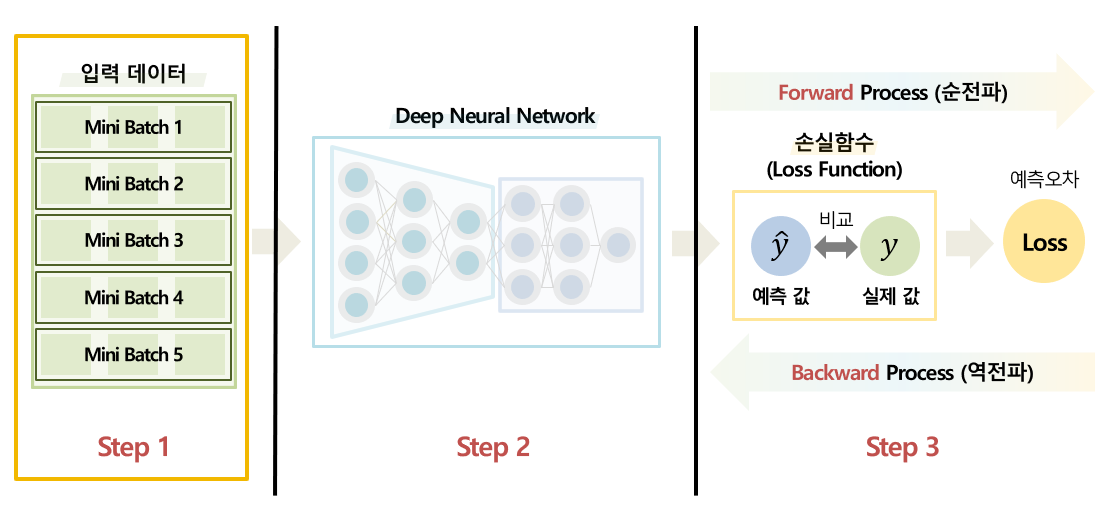

In [10]:
Image('./images/dataset.PNG')

### 실습 데이터셋: [NASDAQ 100 stock data](https://cseweb.ucsd.edu/~yaq007/NASDAQ100_stock_data.html)
* 나스닥 100에 속한 81개 기업의 주가와 나스닥 100지수 값으로 구성
* 2016년 7월 26일부터 2016년 12월 22일까지 수집 (105일)
* 누락된 결측 값에 대해 정제된 데이터

<br/>

* 입력 변수 (X): 81개 종목의 종가
* 출력 변수 (y): NASDAQ 100 지수

### 3-1. 데이터셋 불러오기

In [7]:
data_configs = {
    'data_dir': './data/NASDAQ100/'
}
configs.update(data_configs)
configs

{'device': 'cuda', 'seed': 0, 'data_dir': './data/NASDAQ100/'}

In [8]:
data = pd.read_csv(os.path.join(configs['data_dir'], 'nasdaq100.csv')); data

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.800,97.80,61.1500,95.4000,58.180000,58.00,127.0400,26.6800,165.8100,...,70.7300,45.2300,31.1701,95.2700,81.365,52.160,33.95,48.6100,38.0100,4665.054
1,35.9310,96.890,97.80,61.6100,95.4115,58.190000,58.12,126.0600,26.7300,165.9101,...,70.6900,45.0100,31.1900,94.1700,81.540,52.150,34.10,48.7400,38.1400,4665.054
2,35.9044,96.950,97.57,61.9800,95.5100,58.203333,57.95,126.5100,26.7120,166.1800,...,71.3000,45.0150,31.2100,94.7490,81.530,52.270,34.01,48.9900,38.1500,4665.826
3,35.8900,96.970,97.55,62.0900,95.5200,58.216667,57.96,126.2800,26.7400,166.1480,...,71.3100,45.0200,31.2100,94.3100,81.710,52.300,33.96,48.9500,38.1950,4667.081
4,36.0080,96.960,97.73,61.8900,95.5300,58.230000,58.21,126.5850,26.7200,165.9900,...,71.0600,45.0500,31.1800,94.1550,81.720,52.300,34.17,48.8900,38.3200,4664.491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40555,48.5030,115.880,104.19,73.2895,102.2900,74.690000,67.39,121.1264,32.9200,146.3911,...,73.8100,34.8100,24.7550,72.1400,84.330,70.230,32.04,59.9200,38.5300,4921.811
40556,48.5150,115.875,104.18,73.2900,102.3100,74.675000,67.43,121.2000,32.9300,146.3951,...,73.8100,34.7950,24.7597,72.0928,84.340,70.220,32.03,59.9290,38.5100,4921.580
40557,48.5300,115.875,104.15,73.2850,102.3200,74.680000,67.40,121.3500,32.9064,146.3700,...,73.8001,34.7901,24.7571,72.0600,84.350,70.165,32.03,59.9345,38.5084,4921.884
40558,48.5600,115.920,104.19,73.3000,102.3100,74.750000,67.35,121.3000,32.9200,146.3400,...,73.8101,34.8200,24.7500,72.0950,84.320,70.210,32.04,59.9400,38.5050,4922.949


In [9]:
# 입력 데이터 (X), 출력 데이터 (y) 분리
X, y = data.drop('NDX', axis=1).values, data.NDX.values    # numpy array 형태로 할당
print(X.shape, y.shape)

(40560, 81) (40560,)


### 3-2. 데이터 전처리 (1)

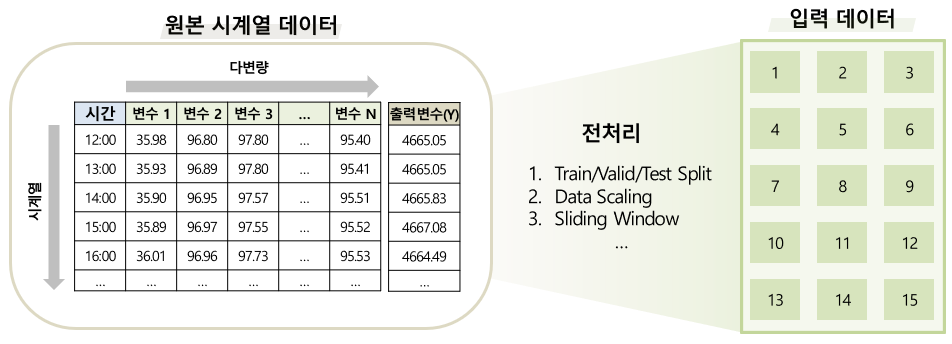

In [3]:
Image('./images/preprocess.PNG')

#### Train / Valid / Test Split

In [13]:
data_configs = {
    'valid_ratio':0.2,
    'test_ratio':0.2,
}

configs.update(data_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'data_dir': './data/NASDAQ100/',
 'valid_ratio': 0.2,
 'test_ratio': 0.2}

In [14]:
"""Train/Valid/Test 분리"""
# shuffle False에 주의! 시계열 데이터는 일반적으로 시간 순으로 train/valid/test를 분리

# Step 1. Train과 Test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=configs['test_ratio'], shuffle=False)

# Step 2. Train 내에서 valid 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=configs['valid_ratio'], shuffle=False)

#### Data Scaling
- 입력 값의 스케일이 유사해지도록 맞추는 작업
- **Train 데이터의 정보만을 활용하여 scaling 수행해야 함에 주의**
    - Train 데이터의 통계량(min,max,mean,std)을 이용하여 Valid/Test에 scaling 수행

In [15]:
data_configs = {
    'scaler':'standard'  # choices=(minmax, standard)
}

configs.update(data_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'data_dir': './data/NASDAQ100/',
 'valid_ratio': 0.2,
 'test_ratio': 0.2,
 'scaler': 'standard'}

In [16]:
# Step 1. Scaler 정의
X_scaler = StandardScaler() if configs['scaler']=='standard' else MinMaxScaler()
y_scaler = StandardScaler() if configs['scaler']=='standard' else MinMaxScaler()

# Step 2. 학습 (TRAIN) 데이터의 통계 정보만으로 scaler를 정의 (fit) 해야 함에 주의
X_scaler.fit(X_train)
y_scaler.fit(y_train.reshape(-1,1))

# Step 3. transform 수행
X_train, X_valid, X_test = X_scaler.transform(X_train), X_scaler.transform(X_valid), X_scaler.transform(X_test)
y_train, y_valid, y_test = y_scaler.transform(y_train.reshape(-1,1)), y_scaler.transform(y_valid.reshape(-1,1)), y_scaler.transform(y_test.reshape(-1,1))

### 3-2. 데이터 전처리 (2)
#### Sliding Window
- 2016년 7월 26일 ~ 2016년 12월 22일 (총 105일) 기간 동안 수집된 데이터
- 각 일자 별로 390개의 관측치가 기록되었으며, 11월 25일에는 210개의 관측치, 12월 22일에는 180개의 관측치가 기록됨
    - 1분 단위로 수집된 데이터 (관측치 별 시간 간격=1분)

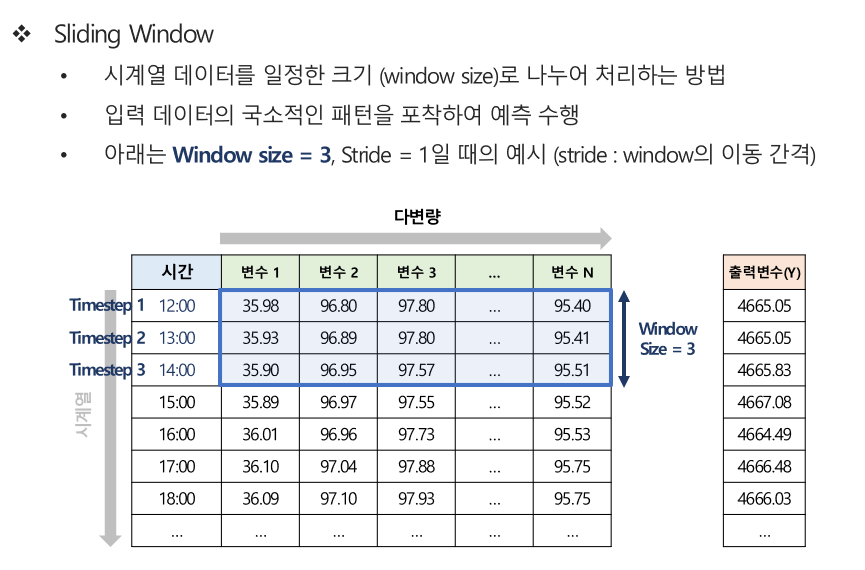

In [19]:
Image('./images/sliding_window1.PNG')

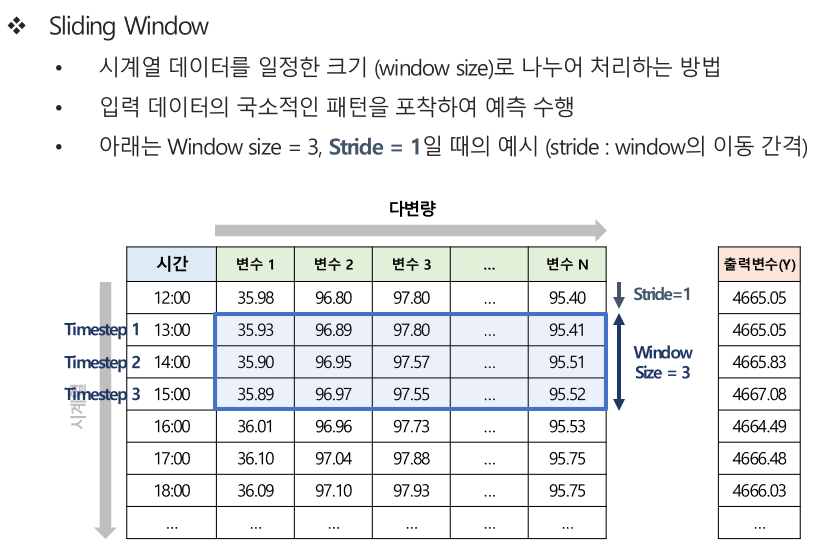

In [20]:
Image('./images/sliding_window2.PNG')

In [17]:
data_configs = {
    'window_size': 5,   # 5 minutes
    'stride' : 1,
    'y_mode' : 'next'   # 'avg', 'last', 'next'
}
configs.update(data_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'data_dir': './data/NASDAQ100/',
 'valid_ratio': 0.2,
 'test_ratio': 0.2,
 'scaler': 'standard',
 'window_size': 5,
 'stride': 1,
 'y_mode': 'next'}

#### Time Series Many to One Regression: y 값 결정
(1) Window 내 y 값의 평균  
(2) Winodw 내 마지막 시점 y 값  
(3) Window 미래 시점의 y 값  

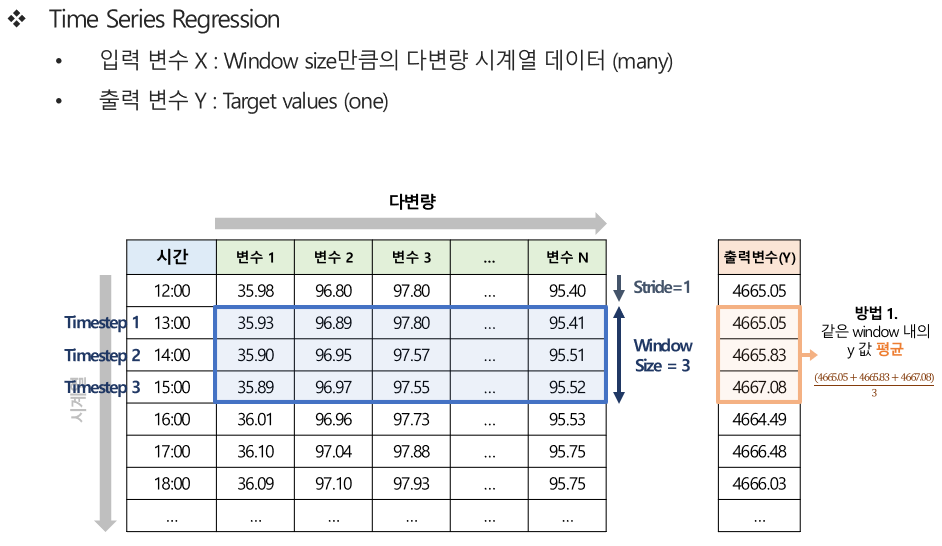

In [21]:
Image('./images/reg_y1.PNG')

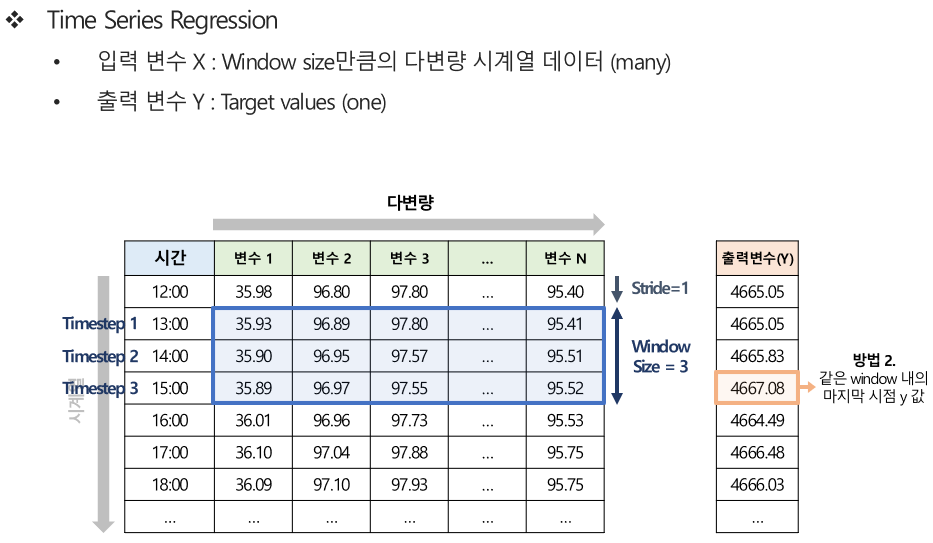

In [22]:
Image('./images/reg_y2.PNG')

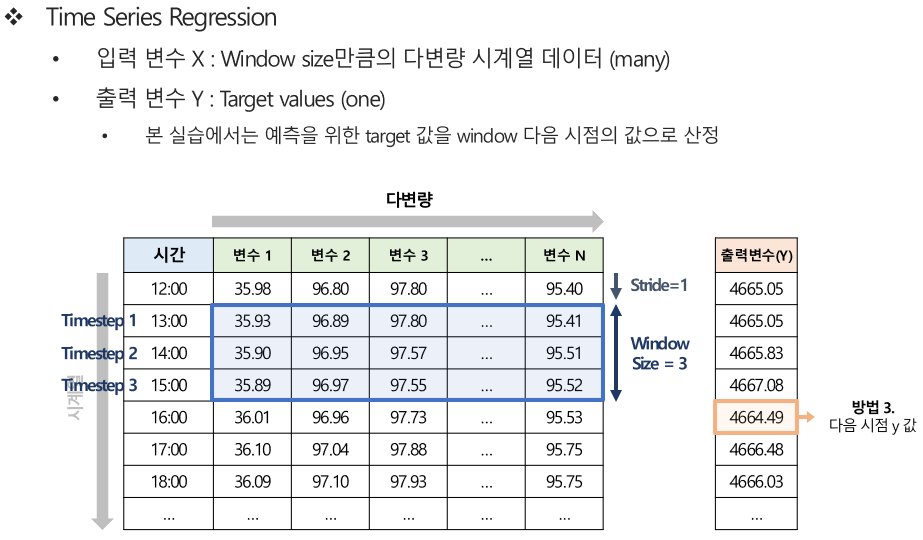

In [23]:
Image('./images/reg_y3.PNG')

In [24]:
def sliding_window(X, y, window_size:int, stride_size:int, y_mode:str):
    """
    Sliding Window를 적용해주는 함수
    - time series data인 X, y를 모두 input으로 받습니다
    - 사용자가 window size (int형), stride size (int형)을 지정해줍니다
    - y_mode:
        (1) "avg"일 시 window 내의 평균
        (2) "last"일 시 마지막 window의 y 값, 
        (3) "next"일 시 window 바로 다음 timestep의 y 값으로 정의합니다.
            - 이 경우, X data의 마지막 window sample은 y 값이 없으므로 샘플을 제거합니다.
    """
    x_window = np.array([X[start:start+window_size] for start in range(0, X.shape[0]-window_size+1, stride_size)]) 

    if y_mode=="avg":
        y_window = np.array([np.mean(y[start:start+window_size]).reshape(-1, 1) for start in range(0, y.shape[0]-window_size+1, stride_size)])
    
    elif y_mode=="last":
        y_window = np.array([y[start+window_size-1] for start in range(0, y.shape[0]-window_size+1, stride_size)])

    elif y_mode=="next":
        y_window = np.array([y[start+window_size] for start in range(0, y.shape[0]-window_size, stride_size)])
        x_window = x_window[:len(y_window)]  # y 관측치 개수와 동일하게 맞추기
        
    return x_window, y_window

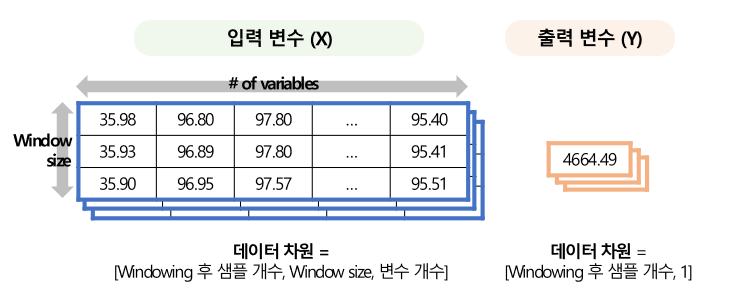

In [27]:
Image('./images/sliding_window_samples.PNG')

In [28]:
## 데이터의 차원 확인 ##

X_train_window, y_train_window = sliding_window(X_train, y_train, configs['window_size'], configs['stride'], y_mode='next')
X_valid_window, y_valid_window = sliding_window(X_valid, y_valid, configs['window_size'], configs['stride'], y_mode='next')
X_test_window, y_test_window = sliding_window(X_test, y_test, configs['window_size'], configs['stride'], y_mode='next')

print(f"학습 데이터의 차원: 입력 데이터 {X_train_window.shape}, 출력 데이터 {y_train_window.shape}")
print(f"검증 데이터의 차원: 입력 데이터 {X_valid_window.shape}, 출력 데이터 {y_valid_window.shape}")
print(f"평가 데이터의 차원: 입력 데이터 {X_test_window.shape}, 출력 데이터 {y_test_window.shape}")

학습 데이터의 차원: 입력 데이터 (25953, 5, 81), 출력 데이터 (25953, 1)
검증 데이터의 차원: 입력 데이터 (6485, 5, 81), 출력 데이터 (6485, 1)
평가 데이터의 차원: 입력 데이터 (8107, 5, 81), 출력 데이터 (8107, 1)


### 3-3. NASDAQ100 Dataset
- 아래의 Custom Dataset을 정의하기 위해서는 앞선 전처리 과정을 모두 거쳐야 합니다.
- 즉, (1) Train/Valid/Test를 나누고 (2) Scaling을 수행한 뒤 (3) Windowing을 해준 뒤의 데이터셋이 X, y로 입력됩니다

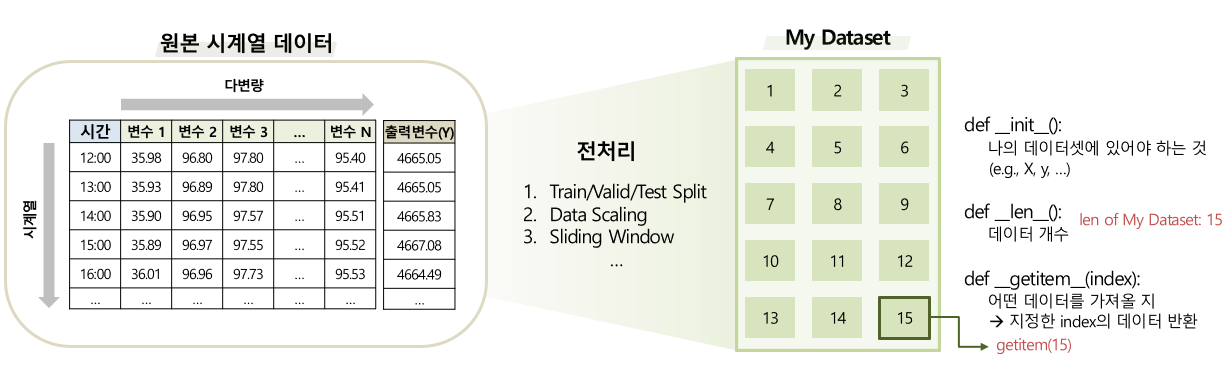

In [4]:
Image('./images/custom_dataset.PNG')

In [30]:
class NASDAQ_Dataset(Dataset):
    def __init__(self, configs, X, y):
        self.configs = configs
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)

    def __getitem__(self, idx):
        return {'X': self.X[idx].float(),
                'y': self.y[idx].float()}
    
    def __len__(self):
        return len(self.y)

    @property
    def input_dim(self):
        # X의 변수 개수 (차원)을 반환
        return self.X.shape[-1]

In [31]:
print(f"학습 데이터의 수: {len(NASDAQ_Dataset(configs, X_train_window, y_train_window))}")
print(f"검증 데이터의 수: {len(NASDAQ_Dataset(configs, X_valid_window, y_valid_window))}")
print(f"평가 데이터의 수: {len(NASDAQ_Dataset(configs, X_test_window, y_test_window))}")

학습 데이터의 수: 25953
검증 데이터의 수: 6485
평가 데이터의 수: 8107


In [32]:
NASDAQ_Dataset(configs, X_train_window, y_train_window).input_dim

81

#### (참고) 위 과정을 모두 함수화 하여 한 번에 처리하는 코드
- (참고) get_data() 함수로 받을 수 있는 X, y 값을 미리 저장해고 불러오는 것이 더 효율적!

In [19]:
class NASDAQ_Dataset2(Dataset):
    def __init__(self, configs, mode:str='train'):
        self.configs = configs
        self.mode = mode

        self.X, self.y = self.get_data(configs['data_dir'])

    def __getitem__(self, idx):
        return {'X': self.X[idx],
                'y': self.y[idx]}
    
    def __len__(self):
        return len(self.y)

    @property
    def input_dim(self):
        return self.X.shape[-1]

    def get_data(self, data_dir):
        # 데이터셋 불러오기
        data = pd.read_csv(os.path.join(data_dir, 'nasdaq100.csv'))

        # 입력/출력 데이터 분리
        X, y = data.drop('NDX', axis=1).values, data.NDX.values

        # Train / Valid / Test 분리
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.configs['test_ratio'], shuffle=False)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=self.configs['valid_ratio'], shuffle=False)

        # Scaling
        X_scaler = StandardScaler() if self.configs['scaler']=='standard' else MinMaxScaler()
        y_scaler = StandardScaler() if self.configs['scaler']=='standard' else MinMaxScaler()

        X_scaler.fit(X_train)
        y_scaler.fit(y_train.reshape(-1, 1))

        X_train, X_valid, X_test = X_scaler.transform(X_train), X_scaler.transform(X_valid), X_scaler.transform(X_test)
        y_train, y_valid, y_test = y_scaler.transform(y_train.reshape(-1,1)), y_scaler.transform(y_valid.reshape(-1,1)), y_scaler.transform(y_test.reshape(-1,1))

        if self.mode == 'train':
            # slding window
            X, y = self.sliding_window(X_train, y_train, self.configs)

        elif self.mode == 'valid':
            X, y = self.sliding_window(X_valid, y_valid, self.configs)

        elif self.mode == 'test':
            X, y = self.sliding_window(X_test, y_test, self.configs)
        
        return torch.FloatTensor(X), torch.FloatTensor(y)
    
    @staticmethod
    def sliding_window(X, y, configs):
        window_size, stride_size = configs['window_size'], configs['stride']
        y_mode = configs['y_mode']

        x_window = np.array([X[start:start+window_size] for start in range(0, X.shape[0]-window_size+1, stride_size)]) 

        if y_mode=="avg":
            y_window = np.array([np.mean(y[start:start+window_size]).reshape(-1, 1) for start in range(0, y.shape[0]-window_size+1, stride_size)])
        
        elif y_mode=="last":
            y_window = np.array([y[start+window_size-1] for start in range(0, y.shape[0]-window_size+1, stride_size)])

        elif y_mode=="next":
            y_window = np.array([y[start+window_size] for start in range(0, y.shape[0]-window_size, stride_size)])
            x_window = x_window[:len(y_window)]  # y 관측치 개수와 동일하게 맞추기
            
        return x_window, y_window

In [20]:
print(f"학습 데이터의 수: {len(NASDAQ_Dataset2(configs, mode='train'))}")
print(f"검증 데이터의 수: {len(NASDAQ_Dataset2(configs, mode='valid'))}")
print(f"평가 데이터의 수: {len(NASDAQ_Dataset2(configs, mode='test'))}")

학습 데이터의 수: 25953
검증 데이터의 수: 6485
평가 데이터의 수: 8107


### DataLoader 정의

In [33]:
data_configs = {
    'batch_size':64
}
configs.update(data_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'data_dir': './data/NASDAQ100/',
 'valid_ratio': 0.2,
 'test_ratio': 0.2,
 'scaler': 'standard',
 'window_size': 5,
 'stride': 1,
 'y_mode': 'next',
 'batch_size': 64}

In [34]:
def get_dataloader(configs):
    trainset = NASDAQ_Dataset(configs, X_train_window, y_train_window)
    validset = NASDAQ_Dataset(configs, X_valid_window, y_valid_window)
    testset = NASDAQ_Dataset(configs, X_test_window, y_test_window)

    trainloader = DataLoader(trainset, batch_size=configs['batch_size'], shuffle=True, drop_last=False)
    validloader = DataLoader(validset, batch_size=configs['batch_size'], shuffle=False, drop_last=False)
    testloader = DataLoader(testset, batch_size=configs['batch_size'], shuffle=False, drop_last=False)

    return trainloader, validloader, testloader

In [35]:
trainloader, validloader, testloader = get_dataloader(configs)

# 학습 데이터셋의 입력 (X) 데이터의 차원 확인
# [데이터 개수, window size = sequence length, dimension of samples]
# [N, L, H_in]
trainloader.dataset.X.shape

torch.Size([25953, 5, 81])

---------------------------

## 4. 모델 정의
- RNN, LSTM, GRU with(out) Attention

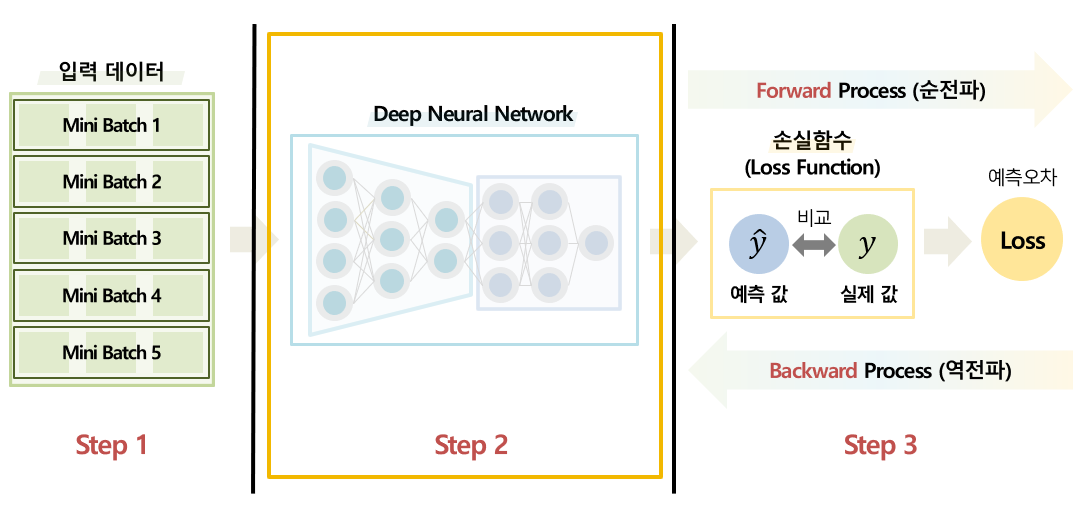

In [36]:
Image('./images/model.PNG')

In [37]:
model_configs = {
    'rnn_type': 'RNN',       # 'RNN', 'LSTM', 'GRU' 중 하나 선택 (str)
    'is_attention':True,     # attention을 활용할 지 하지 않을 지 선택 (bool)
    'return_attention_weight':True, # attention 가중치를 반환할 지 하지 않을 지

    'hidden_size': 64,       # RNN 레이어가 가지는 은닉 노드 수 (int)
    'num_layers': 2,         # RNN 레이어를 몇 개 쌓을지 (int)
    'bidirectional': True,   # 단방향/양방향 여부 (bool: True or False)
    'dropout_rate': .1       # dropout
}

configs.update(model_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'data_dir': './data/NASDAQ100/',
 'valid_ratio': 0.2,
 'test_ratio': 0.2,
 'scaler': 'standard',
 'window_size': 5,
 'stride': 1,
 'y_mode': 'next',
 'batch_size': 64,
 'rnn_type': 'RNN',
 'is_attention': True,
 'return_attention_weight': True,
 'hidden_size': 64,
 'num_layers': 2,
 'bidirectional': True,
 'dropout_rate': 0.1}

In [39]:
class Model(nn.Module):
    def __init__(self, configs, input_dim):
        super(Model, self).__init__()

        self.configs = configs
        self.input_dim = input_dim
        self.hidden_size = configs['hidden_size']      # 64
        self.num_layers = configs['num_layers']        # 1
        self.bidirectional = configs['bidirectional']  # True
        self.dropout_rate = configs['dropout_rate']

        self.rnn_type = configs['rnn_type']
        rnn_type_list = ['RNN', 'LSTM', 'GRU']
        assert self.rnn_type in rnn_type_list  # RNN type model이 RNN, LSTM, GRU 중 하나여야 함

        self.rnn_model = getattr(nn, self.rnn_type)(
            input_size = self.input_dim,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True,
            bidirectional = self.bidirectional,
            dropout = self.dropout_rate
        )

        self.regressor = nn.Linear(in_features=self.hidden_size * 2 if self.bidirectional else self.hidden_size, 
                                    out_features=1)

        # scaled dot product attention!
        self.is_attention = configs['is_attention']
        self.return_attention_weight = configs['return_attention_weight']
        if self.is_attention:
            hidden_size = self.hidden_size * 2 if self.bidirectional else self.hidden_size
            self.scale = 1. / np.sqrt(hidden_size)  # hidden_size 증가에 따라 QK 내적 값이 커져 softmax 출력 값의 분포가 편향되는 것을 방지하기 위함
            self.query_projection = nn.Sequential(
                            nn.Linear(in_features=hidden_size, out_features=hidden_size),
                            nn.Tanh()
                            )
            self.projection = nn.Sequential(
                            nn.Linear(in_features=hidden_size*2, out_features=hidden_size),
                            nn.Tanh()
                            )

    def attention(self, query, keys, values):
        """
        Query : RNN-based Model의 마지막 timestep에 대한 hidden state
            - [batch_size, hidden_size]
        Keys : RNN-based Model의 모든 timestep에 대한 hidden state를 쌓아올린 matrix
            - [batch_size, time_steps, hidden_size]
        Values : Keys와 동일
            - [batch_size, time_steps, hidden_size]
        """
        # query projection
        query = self.query_projection(query)
        
        # calcuate alignmnet scores
        attention_scores = torch.bmm(keys, query.unsqueeze(2))

        # Apply softmax to obtain attention weights (scaing)
        attention_weights = torch.softmax(attention_scores.mul_(self.scale), dim=1)

        # Compute context vector
        context_vector = torch.sum(attention_weights * values, dim=1)

        # Projection
        context_vector = self.projection(torch.cat([query, context_vector], dim=1))

        return context_vector, attention_weights.squeeze()

    def forward(self, x):
        
        # Initial hidden state 초기화
        num_direction = self.num_layers*2 if self.bidirectional else self.num_layers
        h0 = torch.zeros(num_direction, x.size(0), self.hidden_size, device=x.device)

        if self.rnn_type == 'LSTM':
            # lstm의 경우 initial cell state 초기화
            c0 = torch.zeros(num_direction, x.size(0), self.hidden_size, device=x.device)
        
        # 시계열 데이터의 특징 추출
            # out = 모든 timestep에 대한 hidden state 값 (Batch size, Sequence length, D*H_out)
            # last_hidden = 마지막 timestep에 대한 hidden state 값 (D*num_layers, Batch size, H_out)
        init_state = (h0, c0) if self.rnn_type == 'LSTM' else h0
        out, last_hidden = self.rnn_model(x, init_state)

        # 양방향 RNN인 경우: 마지막 layer의 단방향, 역방향 layer hidden state를 결합 (concatenate)
        # 단방향 RNN인 경우: 가장 마지막 timestep에 대한 hidden state 값 
        last_hidden = last_hidden[0] if self.rnn_type == "LSTM" else last_hidden # (hidden states, cell states) 중 hidden states만 선택
        last_out = torch.cat((last_hidden[-2, :, :], last_hidden[-1, :, :]), dim=1) if self.bidirectional else out[:, -1, :]
        
        if self.is_attention:
            # Attention
            last_out, attention_weight = self.attention(query=last_out, keys=out, values=out)

        # 추출된 특징을 regressor에 넣고, 회귀 예측 수행
        pred = self.regressor(last_out)

        return (pred, attention_weight) if self.return_attention_weight else pred

In [40]:
model = Model(configs, trainloader.dataset.input_dim)
model

Model(
  (rnn_model): RNN(81, 64, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (regressor): Linear(in_features=128, out_features=1, bias=True)
  (query_projection): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
  )
  (projection): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
  )
)

----------------------

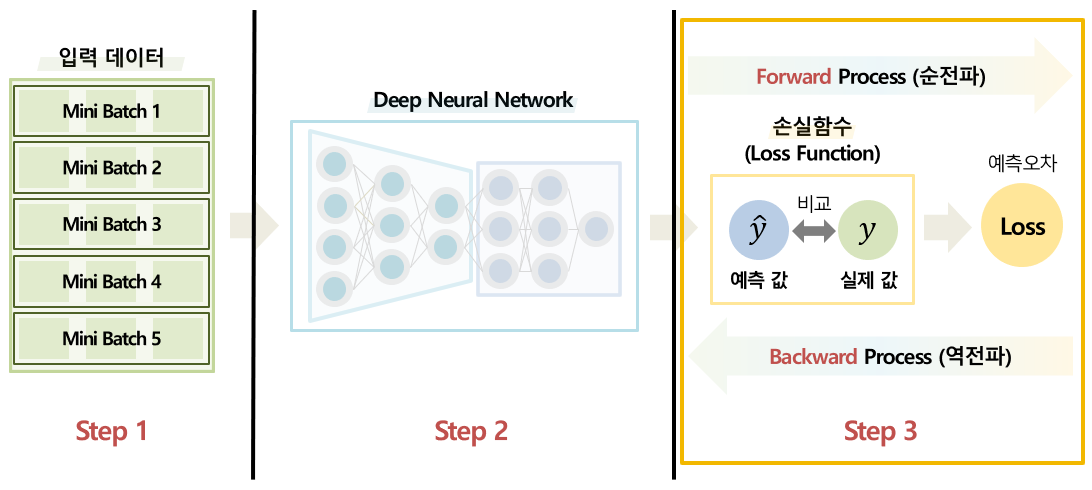

In [42]:
Image('./images/train.PNG')

## 5. Loss Function & Optimizer 정의

### 5-1. Loss Function 정의

In [41]:
criterion = nn.MSELoss()

### 5-2. Optimizer 정의

In [43]:
opt_configs = {
    'optimizer':'adam',
    'lr':1e-4,
    'momentum':0.9,
    'weight_decay':0.0
}

configs.update(opt_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'data_dir': './data/NASDAQ100/',
 'valid_ratio': 0.2,
 'test_ratio': 0.2,
 'scaler': 'standard',
 'window_size': 5,
 'stride': 1,
 'y_mode': 'next',
 'batch_size': 64,
 'rnn_type': 'RNN',
 'is_attention': True,
 'return_attention_weight': True,
 'hidden_size': 64,
 'num_layers': 2,
 'bidirectional': True,
 'dropout_rate': 0.1,
 'optimizer': 'adam',
 'lr': 0.0001,
 'momentum': 0.9,
 'weight_decay': 0.0}

In [44]:
def get_optimizer(configs, model):
    if configs['optimizer'] == "sgd":
        optimizer = optim.SGD(params=model.parameters(), lr=configs['lr'],
                              momentum=configs['momentum'], weight_decay=configs['weight_decay'])

    elif configs['optimizer'] == "adam":
        optimizer = optim.Adam(params=model.parameters(), lr=configs['lr'], 
                                    betas=(configs['momentum'], 0.999), # (momentum, adaptive lr momentum)
                                    weight_decay=configs['weight_decay'])
    else:
        print("Invalid optimizer name, it should be one of ['sgd', 'adam']. Exiting...")
        exit()

    return optimizer

## 6. Forward & Backward

### 6-1. 학습에 필요한 하이퍼파라미터 정의

In [45]:
train_configs = {
    'num_epochs':50,
    'save_dir': './results/regression/',
    'visualize': True,
    'patience':10  # validation loss가 다시 떨어질 때까지 기다리는 epoch 횟수 (이를 넘으면 모델 저장 후 학습 조기종료)
}

configs.update(train_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'data_dir': './data/NASDAQ100/',
 'valid_ratio': 0.2,
 'test_ratio': 0.2,
 'scaler': 'standard',
 'window_size': 5,
 'stride': 1,
 'y_mode': 'next',
 'batch_size': 64,
 'rnn_type': 'RNN',
 'is_attention': True,
 'return_attention_weight': True,
 'hidden_size': 64,
 'num_layers': 2,
 'bidirectional': True,
 'dropout_rate': 0.1,
 'optimizer': 'adam',
 'lr': 0.0001,
 'momentum': 0.9,
 'weight_decay': 0.0,
 'num_epochs': 50,
 'save_dir': './results/regression/',
 'visualize': True,
 'patience': 10}

### 6-2. Train 과정 함수화

In [46]:
def train(device, model, trainloader, criterion, optimizer):
    model.train()
    num_iterations = len(trainloader)
    train_history = {'loss': torch.zeros(num_iterations)}      # 모델의 손실 및 예측 성능을 기록하기 위한 변수
    
    for i, batch in enumerate(trainloader):
        # X, y 데이터 명시, 두 텐서를 모델, 목적함수와 같은 device로
        X, y = batch['X'].to(device), batch['y'].to(device)

        # forward
        # model에 입력 데이터 x를 넣으면 자동으로 forward 함수가 호출되어 prediction 값을 output으로 도출
        pred = model(X)
        pred = pred[0] if len(pred)==2 else pred  # attention weights까지 반환하면 len(pred)는 2가 됨

        # Loss 계산!
        loss = criterion(pred, y)

        """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
        loss.backward()  # PyTorch 자동 미분

        """optimizer를 이용한 파라미터 업데이트"""
        optimizer.step()
        
        """Optimizer Gradient 초기화"""
        optimizer.zero_grad()

        train_history['loss'][i] = loss.item()   # 'item()'은 tensor의 item 값 (상수 값)만 반환. tensor를 직접적으로 리스트에 append하면 불필요하게 메모리가 쌓이는 것 주의.

    train_result = {k: v.mean().item() for k, v in train_history.items()}  # train의 loss, acc를 평균내어 결과 보기 

    return train_result

### 6-3. Valid (Evaluate) 과정 함수화

In [47]:
def evaluate(device, model, validloader, criterion):
    model.eval() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

    num_iterations = len(validloader)
    valid_history = {'loss': torch.zeros(num_iterations)}      # 모델의 손실(loss) 및 예측 성능을 기록하기 위함
    
    with torch.no_grad():  # 자동미분 연산 중지
        for i, batch in enumerate(validloader):
            X, y = batch['X'].to(device), batch['y'].to(device)
            pred = model(X)
            pred = pred[0] if len(pred)==2 else pred

            loss = criterion(pred, y)

            """loss를 backward 하지 않는 것에 주의"""

            valid_history['loss'][i] = loss.item()   # 모델 손실 저장

    valid_result = {k: v.mean().item() for k, v in valid_history.items()}

    return valid_result

### 6-4. 모델 학습 추세 시각화 함수

In [48]:
def visualize_model_training(epoch_history):
    # Loss 추세 시각화
    sns.lineplot(x=range(1, len(epoch_history['train_loss'])+1), y=epoch_history['train_loss'], label="Train Loss")
    sns.lineplot(x=range(1, len(epoch_history['train_loss'])+1), y=epoch_history['valid_loss'], label="Valid Loss")
    plt.title("Train vs Valid Loss Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

### 6-5. 학습이 완료된 모델의 파라미터를 저장하는 함수 (조기종료)
- Save parameters of the trained model!
- earlystop!

In [49]:
class EarlyStopping:
    def __init__(self, patience:int=10, 
                verbose:bool=True, 
                delta:float=0.0, 
                save_dir:str="./best_model.pt"):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.save_dir = save_dir

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}).  Saving model ...')
        
        torch.save(model.state_dict(), os.path.join(self.save_dir, 'best_model.pt'))
        self.val_loss_min = val_loss

### 6-6. Test 과정 함수화

In [60]:
def test(device, save_dir, model, testloader):
    """test model 정의"""
    saved_model = torch.load(os.path.join(save_dir, 'best_model.pt')) # 저장된 모델 불러오기
    model.load_state_dict(saved_model)

    """test 과정에서 pred, true를 모두 반환"""
    test_result = {'pred': [], 'true': [], 'attention_weights': []}

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X, y = batch['X'].to(device), batch['y'].to(device)
            
            pred = model(X)
            pred_ = pred[0] if len(pred)==2 else pred

            test_result['pred'].extend(pred_.squeeze().cpu().numpy())
            test_result['true'].extend(y.squeeze().cpu().numpy())
            attention_weights = pred[1] if len(pred)==2 else torch.ones(pred_.shape).to(pred_.device)
            test_result['attention_weights'].extend(attention_weights.cpu().numpy())

    return test_result

### 6-7. 모든 학습 프레임워크 함수화
- main 함수를 통해 학습을 수행

In [61]:
def main(configs):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    # Device 정의
    device = configs['device']
    
    # seed 정의
    set_seed(configs['seed'])

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")

    save_dir = os.path.join(configs['save_dir'], configs['rnn_type'], 'Attention') if configs['is_attention'] else os.path.join(configs['save_dir'], configs['rnn_type'])
    # 조기 종료 class 호출 (모델 저장을 위함)
    earlystopping = EarlyStopping(configs['patience'], save_dir=save_dir)
    # 모델 저장을 위한 경로 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    # 데이터 불러오기
    trainloader, validloader, testloader = get_dataloader(configs)
    
    # 모델 정의하기
    model = Model(configs, trainloader.dataset.input_dim)
    # GPU로 모델 및 loss function 전송 (CPU에서 계산하는 경우 연산량에 따라 시간이 오래 걸림)
    model, criterion = model.to(device), nn.MSELoss().to(device)

    # optimizer 정의
    optimizer = get_optimizer(configs, model)  # 앞서 정의해두었던 함수 호출

    # training
    best_loss = float('inf')    # 최종적으로 저장할 모델을 판단할 기준 설정 (초기화)
    best_epoch = 0.0            # 최종 모델이 몇 번째 epoch에서 도출되는지 저장 위함 (초기화)
    epoch_history = {'train_loss': [], 'valid_loss': []}

    start = time.time()

    """Step 2: 학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):  

        print('-'*15, f'Epoch: {epoch}', '-'*15)

        train_result = train(device, model, trainloader, criterion, optimizer)     # 앞서 정의해두었던 함수 호출
        valid_result = evaluate(device, model, validloader, criterion)  # 앞서 정의해두었던 함수 호출

        print(f"Train Loss: {train_result['loss']:.4f}")
        print(f"Valid Loss: {valid_result['loss']:.4f}")

        """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
        epoch_history['train_loss'].append(train_result['loss'])
        epoch_history['valid_loss'].append(valid_result['loss'])

        """Step 4: 모델을 평가 (valid/eval) 하였을 때 성능 측면에서 가장 우수했던 모델을 저장"""
        earlystopping(valid_result['loss'], model)
        if valid_result['loss'] < best_loss:
            best_loss = valid_result['loss']  # best acc 값 업데이트
            best_epoch = epoch                # best epoch 값 업데이트

        if earlystopping.early_stop:
            break

    # 최종적으로 선택된 모델에 대한 값 확인
    print(f"Best Valid MSE:{best_loss:.2f} | Best Epoch:{best_epoch}")

    # 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(epoch_history)

    """Step 5: 모델 최종 성능 평가"""
    test_result = test(device, save_dir, model, testloader)

    # 학습/테스트에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return test_result

Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/NASDAQ100/', 'valid_ratio': 0.2, 'test_ratio': 0.2, 'scaler': 'standard', 'window_size': 5, 'stride': 1, 'y_mode': 'next', 'batch_size': 64, 'rnn_type': 'RNN', 'is_attention': True, 'return_attention_weight': True, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/regression/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 0.05
Valid Loss: 0.44
Validation loss decreased (inf --> 0.4448).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 0.01
Valid Loss: 0.38
Validation loss decreased (0.4448 --> 0.3762).  Saving model ...
--------------- Epoch: 3 ---------------
Train Loss: 0.00
Valid Loss: 0.37
Validation loss decreased (0.3762 --> 0.3674).  Saving model ...
--------------- Epoch: 4 ---------------
Train Loss: 0.00

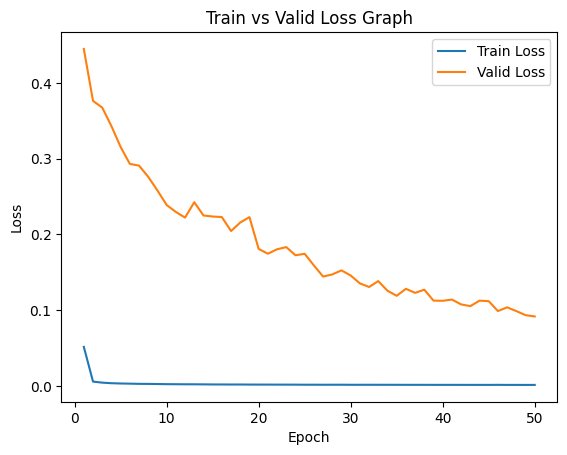

Total Training Time: 1.90 minutes


In [53]:
# 최종 main 함수 실행!!
test_result = main(configs)

### 6-8. Test 결과 확인
- 모델 성능 평가

In [54]:
# Regression Task 평가지표

def return_result(y_true,y_pred):
    performance = dict()
    performance['corr'] = stats.pearsonr(y_true, y_pred)[0]
    performance['r2'] = r2_score(y_true=y_true, y_pred=y_pred)
    performance['mape'] = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    performance['rmse'] = mean_squared_error(y_true=y_true,y_pred=y_pred, squared=True)
    performance['mae'] = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    
    return performance

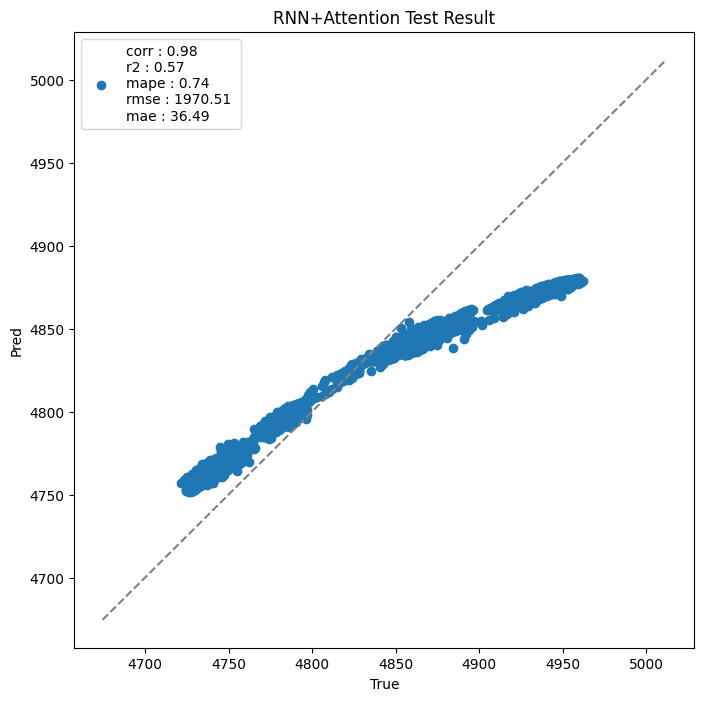

In [55]:
# 시각화

true = y_scaler.inverse_transform(pd.DataFrame(test_result['true'])).squeeze()
pred = y_scaler.inverse_transform(pd.DataFrame(test_result['pred'])).squeeze()

vmin = np.min(np.concatenate([pred, true])) * 0.99
vmax = np.max(np.concatenate([pred, true])) * 1.01

plt.figure(figsize=(8, 8))
p = return_result(true, pred)
v = list(p.values())
perf_legend = f'corr : {v[0]:.2f} \nr2 : {v[1]:.2f} \nmape : {v[2]:.2f} \nrmse : {v[3]:.2f} \nmae : {v[4]:.2f}'
plt.scatter(true, pred, label=perf_legend)
plt.plot([vmin, vmax], [vmin, vmax], color='grey', linestyle='--')
plt.xlabel('True')
plt.ylabel('Pred')
plt.legend(loc='upper left')
backbone = configs['rnn_type']+"+Attention" if configs['is_attention'] else configs['rnn_type']
plt.title(f"{backbone} Test Result");

----

## 7. 비교 실험

### 7-1. 학습 수행

Experiment: Model_RNN, Attention_False
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/NASDAQ100/', 'valid_ratio': 0.2, 'test_ratio': 0.2, 'scaler': 'standard', 'window_size': 5, 'stride': 1, 'y_mode': 'next', 'batch_size': 64, 'rnn_type': 'RNN', 'is_attention': False, 'return_attention_weight': False, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/regression/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 0.0492
Valid Loss: 0.6497
Validation loss decreased (inf --> 0.6497).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 0.0085
Valid Loss: 0.4993
Validation loss decreased (0.6497 --> 0.4993).  Saving model ...
--------------- Epoch: 3 ---------------
Train Loss: 0.0061
Valid Loss: 0.4261
Validation loss decreased (0.4993 --> 0.4261).  Saving model ...
----

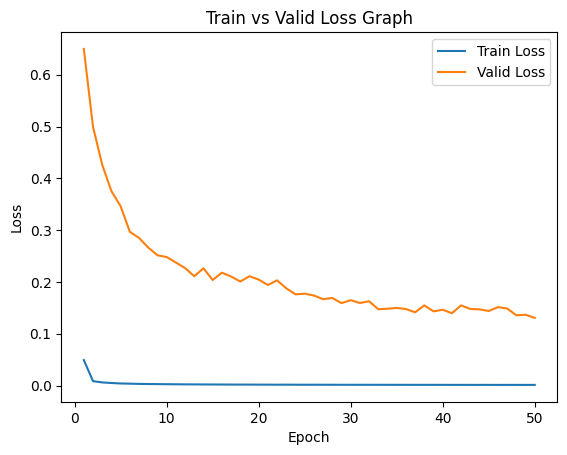

Total Training Time: 1.55 minutes
Experiment: Model_RNN, Attention_True
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/NASDAQ100/', 'valid_ratio': 0.2, 'test_ratio': 0.2, 'scaler': 'standard', 'window_size': 5, 'stride': 1, 'y_mode': 'next', 'batch_size': 64, 'rnn_type': 'RNN', 'is_attention': True, 'return_attention_weight': True, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/regression/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 0.0513
Valid Loss: 0.4395
Validation loss decreased (inf --> 0.4395).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 0.0056
Valid Loss: 0.3927
Validation loss decreased (0.4395 --> 0.3927).  Saving model ...
--------------- Epoch: 3 ---------------
Train Loss: 0.0042
Valid Loss: 0.3535
Validation loss decreased (0.3927 --> 

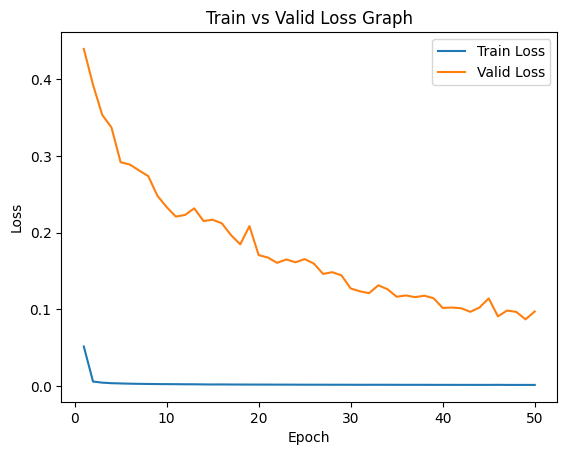

Total Training Time: 1.91 minutes
Experiment: Model_LSTM, Attention_False
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/NASDAQ100/', 'valid_ratio': 0.2, 'test_ratio': 0.2, 'scaler': 'standard', 'window_size': 5, 'stride': 1, 'y_mode': 'next', 'batch_size': 64, 'rnn_type': 'LSTM', 'is_attention': False, 'return_attention_weight': False, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/regression/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 0.1467
Valid Loss: 1.5653
Validation loss decreased (inf --> 1.5653).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 0.0053
Valid Loss: 1.3290
Validation loss decreased (1.5653 --> 1.3290).  Saving model ...
--------------- Epoch: 3 ---------------
Train Loss: 0.0038
Valid Loss: 1.1819
Validation loss decreased (1.3290

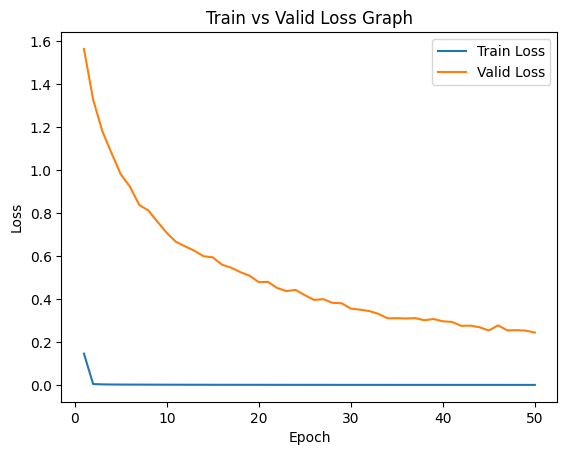

Total Training Time: 1.54 minutes
Experiment: Model_LSTM, Attention_True
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/NASDAQ100/', 'valid_ratio': 0.2, 'test_ratio': 0.2, 'scaler': 'standard', 'window_size': 5, 'stride': 1, 'y_mode': 'next', 'batch_size': 64, 'rnn_type': 'LSTM', 'is_attention': True, 'return_attention_weight': True, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/regression/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 0.1216
Valid Loss: 1.5279
Validation loss decreased (inf --> 1.5279).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 0.0045
Valid Loss: 1.2657
Validation loss decreased (1.5279 --> 1.2657).  Saving model ...
--------------- Epoch: 3 ---------------
Train Loss: 0.0035
Valid Loss: 1.0922
Validation loss decreased (1.2657 --

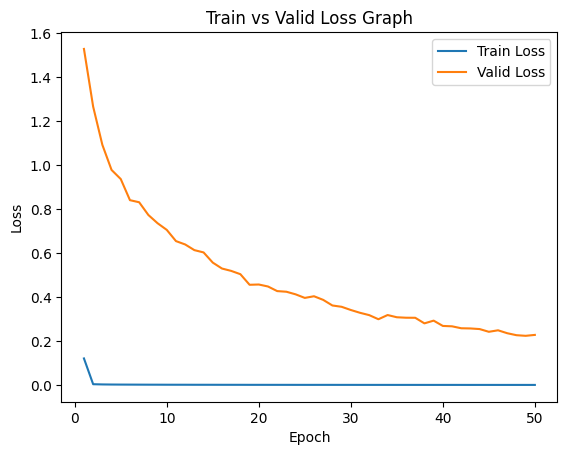

Total Training Time: 1.93 minutes
Experiment: Model_GRU, Attention_False
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/NASDAQ100/', 'valid_ratio': 0.2, 'test_ratio': 0.2, 'scaler': 'standard', 'window_size': 5, 'stride': 1, 'y_mode': 'next', 'batch_size': 64, 'rnn_type': 'GRU', 'is_attention': False, 'return_attention_weight': False, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/regression/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 0.1170
Valid Loss: 0.9688
Validation loss decreased (inf --> 0.9688).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 0.0071
Valid Loss: 0.6692
Validation loss decreased (0.9688 --> 0.6692).  Saving model ...
--------------- Epoch: 3 ---------------
Train Loss: 0.0053
Valid Loss: 0.5593
Validation loss decreased (0.6692 -

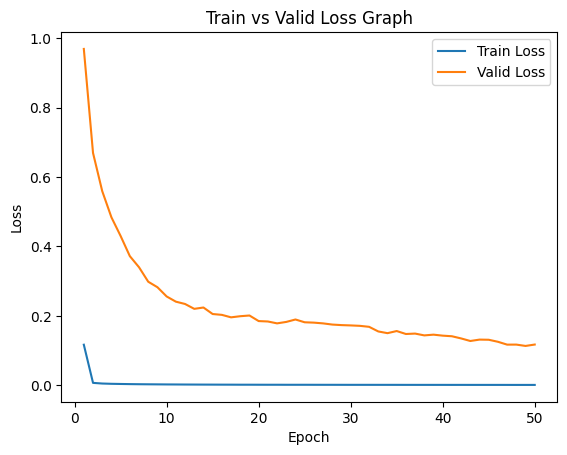

Total Training Time: 1.51 minutes
Experiment: Model_GRU, Attention_True
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/NASDAQ100/', 'valid_ratio': 0.2, 'test_ratio': 0.2, 'scaler': 'standard', 'window_size': 5, 'stride': 1, 'y_mode': 'next', 'batch_size': 64, 'rnn_type': 'GRU', 'is_attention': True, 'return_attention_weight': True, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/regression/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 0.0668
Valid Loss: 0.4951
Validation loss decreased (inf --> 0.4951).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 0.0052
Valid Loss: 0.4024
Validation loss decreased (0.4951 --> 0.4024).  Saving model ...
--------------- Epoch: 3 ---------------
Train Loss: 0.0042
Valid Loss: 0.3617
Validation loss decreased (0.4024 --> 

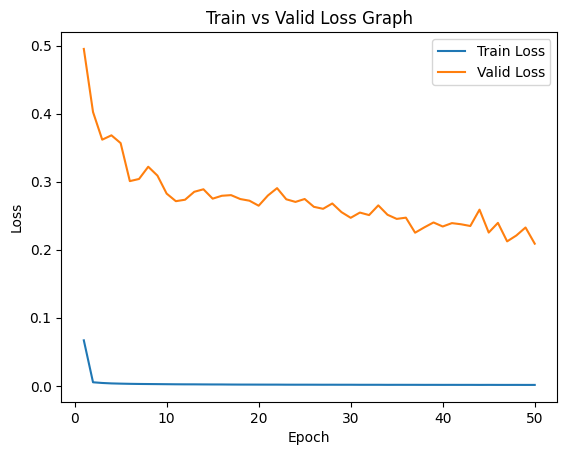

Total Training Time: 1.89 minutes


In [62]:
rnn_type_list = ['RNN', 'LSTM', 'GRU']
attention = [False, True]

for rnn_type in rnn_type_list:
    configs['rnn_type'] = rnn_type

    for is_attn in attention:
        configs['is_attention'] = is_attn
        configs['return_attention_weight'] = is_attn

        print(f"Experiment: Model_{configs['rnn_type']}, Attention_{configs['is_attention']}")

        main(configs)

### 7-2. Test

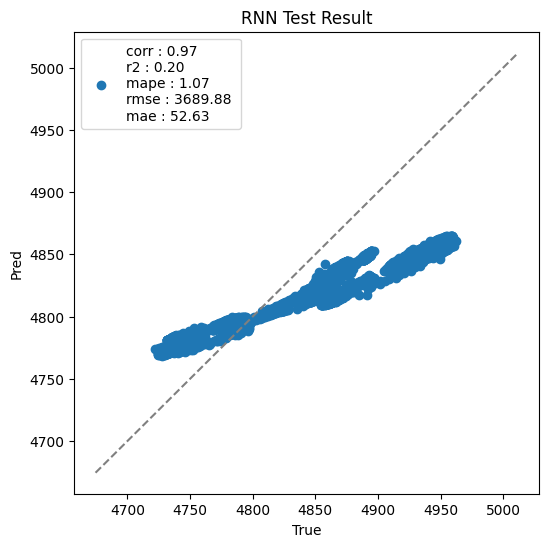

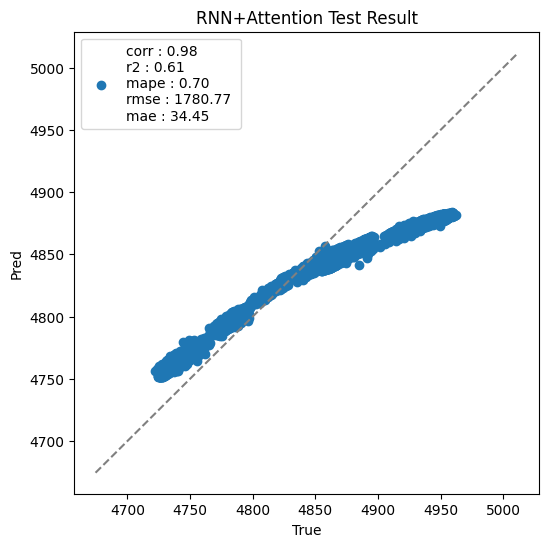

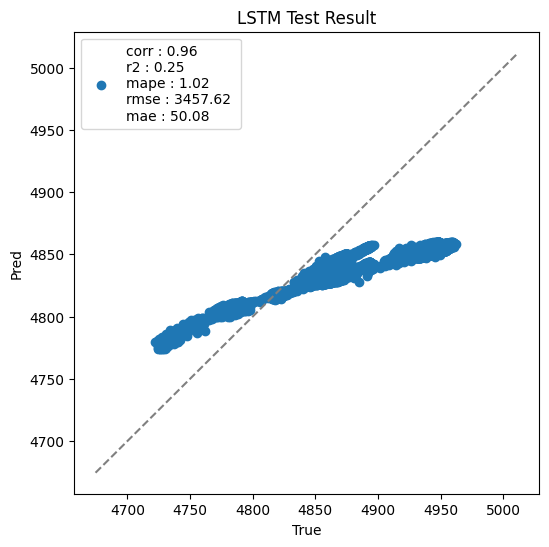

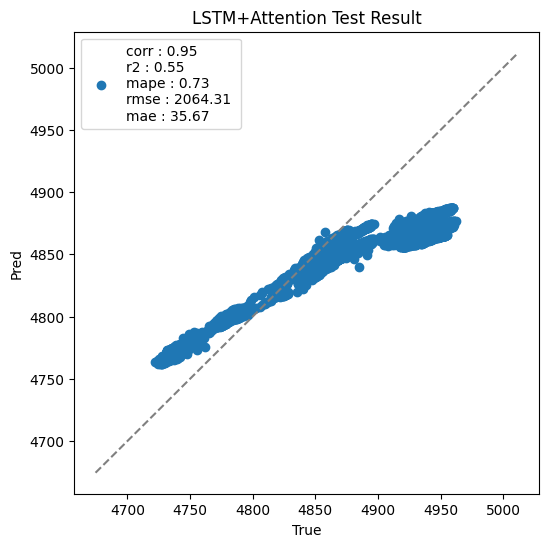

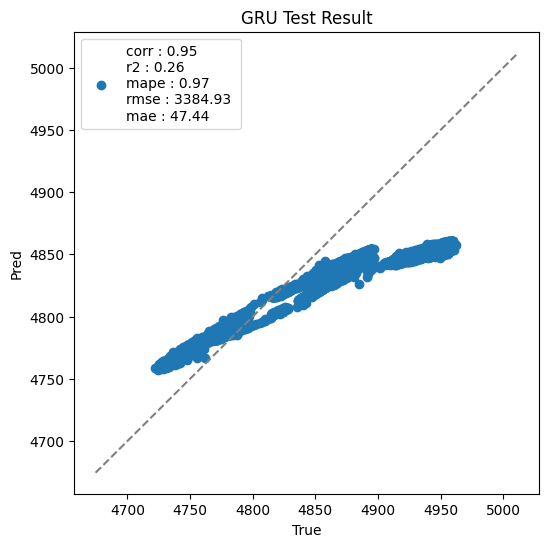

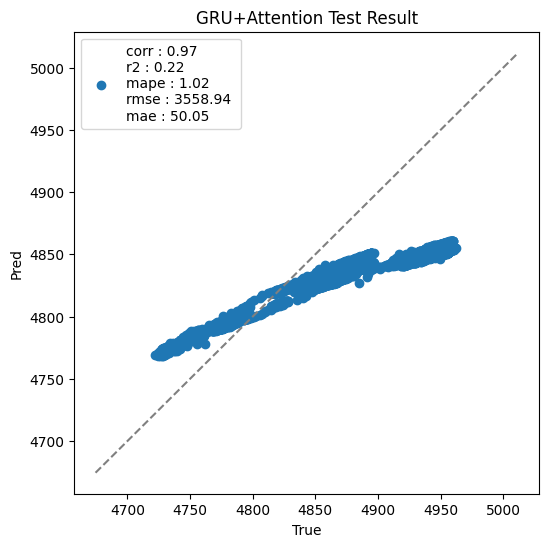

In [63]:
rnn_type_list = ['RNN', 'LSTM', 'GRU']
attention = [False, True]
save_dir_list, test_results = [], []

model = Model(configs, trainloader.dataset.input_dim)

for rnn_type in rnn_type_list:
    configs['rnn_type'] = rnn_type

    for is_attn in attention:
        configs['is_attention'] = is_attn
        configs['return_attention_weight'] = is_attn

        model = Model(configs, trainloader.dataset.input_dim).to(configs['device'])
        save_dir = os.path.join(configs['save_dir'], configs['rnn_type'], 'Attention') if configs['is_attention'] else os.path.join(configs['save_dir'], configs['rnn_type'])
        model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pt')))
        test_result = test(configs['device'], save_dir, model, testloader)
        # test_results.append(test_result)

        true = y_scaler.inverse_transform(pd.DataFrame(test_result['true'])).squeeze()
        pred = y_scaler.inverse_transform(pd.DataFrame(test_result['pred'])).squeeze()

        vmin = np.min(np.concatenate([pred, true])) * 0.99
        vmax = np.max(np.concatenate([pred, true])) * 1.01

        plt.figure(figsize=(6, 6))
        p = return_result(true, pred)
        v = list(p.values())
        perf_legend = f'corr : {v[0]:.2f} \nr2 : {v[1]:.2f} \nmape : {v[2]:.2f} \nrmse : {v[3]:.2f} \nmae : {v[4]:.2f}'
        plt.scatter(true, pred, label=perf_legend)
        plt.plot([vmin, vmax], [vmin, vmax], color='grey', linestyle='--')
        plt.xlabel('True')
        plt.ylabel('Pred')
        plt.legend(loc='upper left')
        backbone = configs['rnn_type']+"+Attention" if configs['is_attention'] else configs['rnn_type']
        plt.title(f"{backbone} Test Result")
        plt.show();